In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle

In [ ]:
# !kaggle datasets download -d adityajn105/flickr8k

 99% 1.03G/1.04G [00:06<00:00, 122MB/s] 
100% 1.04G/1.04G [00:06<00:00, 161MB/s]


In [ ]:
# import zipfile
# zipfile=zipfile.ZipFile("/content/flickr8k.zip")
# zipfile.extractall("/content/kaggle/input/flickr8k")
# zipfile.close()

In [ ]:
# !mkdir /content/kaggle/working/

In [1]:
import os
import pickle
import numpy as np
from tqdm import *
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import *
import pandas as pd


In [2]:
 BASE_DIR='data/input'
 WORKING_DIR='data/Working'

In [3]:
model=VGG16()
model=Model(inputs=model.inputs
            ,outputs=model.layers[-2].output
            )

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
features={}
directory=os.path.join(BASE_DIR,'Images')
directory

'data/input\\Images'

In [6]:
os.listdir(directory)[:5]

['.ipynb_checkpoints',
 '1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg']

In [6]:
# for img_name in tqdm(os.listdir(directory)):
#     img_path=directory+ '/'+ img_name
#     image=load_img(img_path,target_size=(224,224))
#     image=img_to_array(image)
#     image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
#     image=preprocess_input(image)
#     feature=model.predict(image,verbose=0)
#     imageid=img_name.split('.')[0]
#     features[imageid]=feature



In [7]:
# features['3226254560_2f8ac147ea'].shape

In [8]:
# #storing features in pkl format

# pickle.dump(features,open(os.path.join(WORKING_DIR,"features.pkl"),'wb'))

In [9]:
with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f:
    features=pickle.load(f)

In [10]:
with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
    next(f)
    captions_doc=f.read()

In [11]:
features['3226254560_2f8ac147ea'].shape

(1, 4096)

In [12]:
mapping={}
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line)<2:
        continue
    image_id,caption=tokens[0],tokens[1:]
    #remoive .jpg from imageid
    image_id=image_id.split('.')[0]
    #we have a list of string and we have to convert it into string
    caption=" ".join(caption)
    if image_id not in mapping:
        mapping[image_id]=[]
    mapping[image_id].append(caption)

100%|████████████████████████████████████████████████████████████████████████| 40456/40456 [00:00<00:00, 477236.46it/s]


In [13]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            caption=captions[i]
            caption=caption.lower()
            caption=caption.replace('[^A-Za-z]','')
            caption=caption.replace('\s+',' ')
            caption='startseq ' + " ".join([word for word in caption.split() if len(word)>1])+' endseq'
            captions[i]=caption

In [15]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [16]:
clean(mapping)

In [17]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [18]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [19]:
all_captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [20]:
len(all_captions)


40455

In [21]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [22]:
vocab_size

8485

In [23]:
# tokenizer.index_word

In [24]:
max_length=max(len(caption.split()) for caption in all_captions)

In [25]:
max_length

35

# Train Test Split

In [26]:
image_ids=list(mapping.keys())


In [27]:
split=int(len(image_ids)*0.90)

In [28]:
train=image_ids[:split]
test=image_ids[split:]

In [29]:
print(len(train))
print(len(test))

7281
810


In [30]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [31]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [32]:
def data_genrator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    x1,x2,y=list(),list(),list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            captions=mapping[key]
            for caption in captions:
                seq=tokenizer.texts_to_sequences([caption])[0]
                #split in x and y pair
                for i in range(1,len(seq)):
                    in_seq,out_seq=seq[:i],seq[i]
                    #pad
                    in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
                    #catagorical out seq
                    out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]

                    #store
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)
            if n== batch_size:
                x1,x2,y=np.array(x1),np.array(x2),np.array(y)
                yield[x1,x2],y
                x1, x2, y = list(), list(), list()
                n = 0


## creating a model

In [33]:
inputs1=Input(shape=(4096,),name="Image Features")
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)

inputs2=Input(shape=(max_length,),name='Caption')
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)


decoder1=add([fe2,se3])
decoder2=Dense(255,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)


model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [34]:
plot_model(model,show_layer_activations=True,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [35]:
# epochs = 10
# batch_size = 32
# steps = len(train) // batch_size

# for i in range(epochs):
#     # create data generator
#     generator = data_genrator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#     # fit for one epoch
#     model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [36]:
import tensorflow as tf
model = tf.keras.models.load_model('data/Working/best_model.h5')


In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Caption (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 Image Features (InputLayer)    [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 256)      2172160     ['Caption[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['Image Features[0][0]']         
                                                                                            

# genrating captions


In [38]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [39]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [40]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|████████████████████████████████████████████████████████████████████████████████| 810/810 [08:28<00:00,  1.59it/s]


BLEU-1: 0.546726
BLEU-2: 0.329967


In [41]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual Hai---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual Hai---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing in the grass endseq


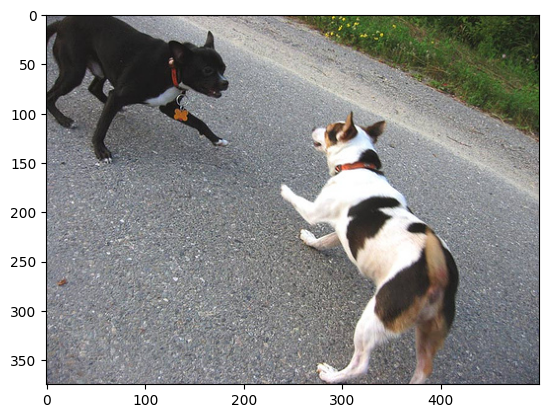

In [42]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual Hai---------------------
startseq couple watches boat against skyline endseq
startseq "a man and woman sit on bench watching boat go by ." endseq
startseq the sun is setting while man and woman watch boat go by endseq
startseq two people sit on bench and watch boat on the water endseq
startseq two people watching boat sail past endseq
--------------------Predicted--------------------
startseq two people are sitting on the edge of water endseq


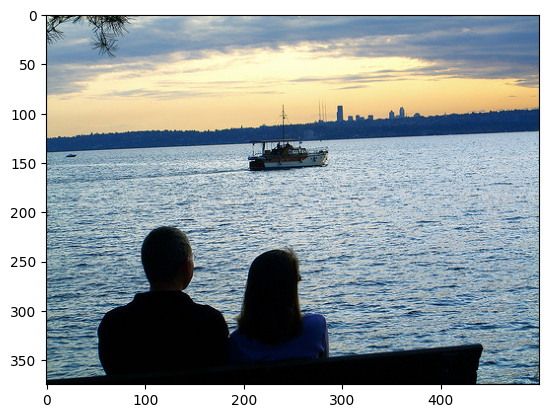

In [43]:
generate_caption("44129946_9eeb385d77.jpg")

In [44]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [45]:
image_path = 'data/input/Images/94232465_a135df2711.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq man in black and white coat is sitting on the water endseq'

In [46]:
image_path = 'data/input/Images/55470226_52ff517151.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq woman in red coat is climbing up snowy hill endseq'

In [47]:
image_path = 'data/input/Images/55473406_1d2271c1f2.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq person in red jacket is snowboarding on snowy hill endseq'

---------------------Actual Hai---------------------
startseq man at the top of mountain with beautiful view in the background endseq
startseq man is sitting on snowbank endseq
startseq man on snowy peak endseq
startseq person in red snow gear is kneeling on snowy ridge under blue sky endseq
startseq mountain climber in red suit poses on snowy peak with mountains in the background endseq
--------------------Predicted--------------------
startseq person in red jacket is snowboarding on snowy hill endseq


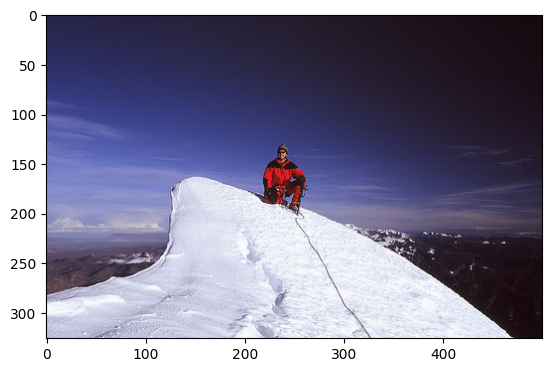

In [48]:
generate_caption("55473406_1d2271c1f2.jpg")